In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

from invisible_cities.io.pmaps_io      import load_pmaps
from invisible_cities.icaro.hst_functions    import shift_to_bin_centers
from invisible_cities.core.core_functions import weighted_mean_and_std

from collections import defaultdict
import invisible_cities.database.load_db as dbf

Running on  Thu Feb 22 00:02:03 2018


In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15

profOpt = "--k"
fitOpt  = "r"

### List of files

In [4]:
files = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/diffusion/4670/pmaps_0*_4670_v0.9.3_20171128_double_kr1300.h5")

run = 4670
SiPM_db = dbf.DataSiPM(run)

### Declare range and binnings

In [5]:
SBins = {'S1_Number' : [ np.linspace(  -0.5,      10.5,   11 + 1) ],
         'S1_Width'  : [ np.linspace( -0.01,      0.99,   40 + 1) ],
         'S1_Height' : [ np.linspace(     0,        10,   10 + 1) ],
         'S1_Energy' : [ np.linspace(     0,        50,   50 + 1) ],
         'S1_Charge' : [ np.linspace(     0,         2,   20 + 1) ],
         'S1_Time'   : [ np.linspace(     0,       650,  650 + 1) ],

         'S2_Number' : [ np.linspace(  -0.5,      10.5,   11 + 1) ],
         'S2_Width'  : [ np.linspace(     0,        50,   50 + 1) ],
         'S2_Height' : [ np.linspace(     0,      8000,  100 + 1) ],
         'S2_Energy' : [ np.linspace(     0,      20e3,  100 + 1) ],
         'S2_Charge' : [ np.linspace(     0,      3500,  100 + 1) ],
         'S2_Time'   : [ np.linspace(   640,      1300,  660 + 1) ],
        
         'S2_NSiPM'  : [ np.linspace(     0,       500,  500 + 1) ], 
         'S2_IdSiPM' : [ np.linspace(  -0.5,    1792.5, 1793 + 1) ], 
         'S2_QSiPM'  : [ np.linspace(     0,       100,  100 + 1) ], 
         'S2_XSiPM'  : [ np.linspace(  -200,       200,   40 + 1) ]} #Bin limits and number of bins
        

SLabels = {'S1_Number' :      ["S1 number (#)"],
           'S1_Width'  : [r"S1 width ($\mu$s)"],
           'S1_Height' :    ["S1 height (pes)"],
           'S1_Energy' :    ["S1 energy (pes)"],
           'S1_Charge' :    ["S1 charge (pes)"],
           'S1_Time'   :  [r"S1 time ($\mu$s)"],

           'S2_Number' :      ["S2 number (#)"],
           'S2_Width'  : [r"S2 width ($\mu$s)"],
           'S2_Height' :    ["S2 height (pes)"],
           'S2_Energy' :    ["S2 energy (pes)"],
           'S2_Charge' :    ["S2 charge (pes)"],
           'S2_Time'   :  [r"S2 time ($\mu$s)"],
           
           'S2_NSiPM'  :    ['SiPM number (#)'],
           'S2_IdSiPM' :            ['SiPM id'],
           'S2_QSiPM'  :  ['SiPM charge (pes)']}


exception = ['S1_Energy', 'S1_Number', 'S1_Time']
bin_sel = lambda x: ('S2' not in x) and (x not in exception)
for param in filter(bin_sel, list(SBins)):
    SBins  ['S1_Energy_' + param] = SBins['S1_Energy']   + SBins[param]
    SLabels['S1_Energy_' + param] = SLabels['S1_Energy'] + SLabels[param]

SBins  ['S1_Time_S1_Energy'] = SBins['S1_Time']   + SBins['S1_Energy']
SLabels['S1_Time_S1_Energy'] = SLabels['S1_Time'] + SLabels['S1_Energy']


exception = ['S2_Energy', 'S2_Number', 'S2_Time']
bin_sel = lambda x: ('S1' not in x) and (x not in exception) and ('SiPM' not in x)
for param in filter(bin_sel, list(SBins)):
    SBins  ['S2_Energy_' + param] = SBins['S2_Energy']   + SBins[param]
    SLabels['S2_Energy_' + param] = SLabels['S2_Energy'] + SLabels[param]
    
SBins  ['S2_Time_S2_Energy'] = SBins['S2_Time']   + SBins['S2_Energy']
SLabels['S2_Time_S2_Energy'] = SLabels['S2_Time'] + SLabels['S2_Energy']

SBins  ['S2_Energy_S1_Energy'] = SBins['S2_Energy']   + SBins['S1_Energy']
SLabels['S2_Energy_S1_Energy'] = SLabels['S2_Energy'] + SLabels['S1_Energy']

SBins  ['S2_XYSiPM'] = SBins['S2_XSiPM'] + SBins['S2_XSiPM']
SLabels['S2_XYSiPM'] = ['X pos (mm)', 'Y pos (mm)']

del SBins['S2_XSiPM']

### Writer declaration

In [6]:
def hist_writer_var(file, *, compression = 'ZLIB4'):
    
    def write_hist(group_name  : 'options: HIST, HIST2D',
                   table_name  : 'histogram name',
                   entries     : 'np.array with bin content',
                   bins        : 'list of np.array of bins',
                   out_of_range: 'np.array lenght=2 with events out of range',
                   errors      : 'np.array with bins uncertainties',
                   labels      : 'list with labels of the histogram'):
        
        try:                       hist_group = getattr          (file.root, group_name)
        except tb.NoSuchNodeError: hist_group = file.create_group(file.root, group_name)

        if table_name in hist_group:
            raise ValueError("Histogram {} already exists".format(table_name))
            
        file.create_array(hist_group, table_name, entries)
        vlarray = file.create_vlarray(hist_group, table_name + '_bins', atom=tb.Float64Atom(shape=()))
        for ibin in bins:
            vlarray.append(np.array(ibin))
        file.create_array(hist_group, table_name + '_outRange', out_of_range)
        file.create_array(hist_group, table_name + '_errors', errors)
        file.create_array(hist_group, table_name + '_labels', labels)
                    
    return write_hist

### Monitoring class declaration

In [7]:
class Histogram:
    def __init__(self, title, bins, labels, values = None):
        """
        This class represents a histogram with is a parameter holder that contains data grouped by bins.
        
        Attributes:
    
        title     = String with the histogram title
        bins      = List with the histogram binning. 
        data      = Array with the accumulated entries on each bin. 
        out_range = Array with the Accumulated counts out of the bin range.
                    Values are n-dim arrays of lenght 2 (first element is underflow, second oveflow).
        errors    = Array with the assigned uncertanties to each bin.
    
        Arguments:
    
        bins   = List containing the histogram binning. 
        values = Array with initial values, optional. 
                 If not passed, then the initial bin content is set to zero.
        """        
        
        self.title     = title
        self.bins      = bins        
        self.data      = self.init_from_bins()
        self.out_range = np.zeros((2,) * len(bins))
        self.errors    = self.init_from_bins()
        self.labels    = labels
        
        if values:
            self.fill(np.asarray(values))
            
    def init_from_bins(self):
        "Encapsulation for histogram initialization to 0"
        return np.zeros(shape=[len(x) - 1 for x in self.bins])
    
    def fill(self, additive, data_weights=[]):
        """
        Given a dictionary holding data (keys are parameters, values is 
        a list with the parameter values), bins it and adds it to the 
        stored bin content.
        
        additive = Dictionary holding the data to fill the histogram.
        """
        if len(data_weights) != len(additive.T):
            data_weights = np.ones(len(additive.T))

        binnedData, outRange = self.bin_data(np.asarray(additive), self.bins, data_weights)
        
        self.data      += binnedData
        self.out_range += outRange
        self.update_errors()    
                        
    def bin_data(self, data, histbins, data_weights): 
        """
        Bins the given data and computes the events out of range.
        """        
        binned_data = np.histogramdd(data.T, histbins, weights=data_weights)[0]        
        if len(histbins) == 1:
            out_of_range = [len(data[data < histbins[0][0]]), len(data[data > histbins[0][-1]])]
        else:
            out_of_range = [[len(data[i][data[i] < bins[0]]), len(data[i][data[i] > bins[-1]])] for i, bins in enumerate(histbins)]

        return binned_data, out_of_range        

    def update_errors(self, errors=None):
        """
        Updates the errors with the passed list/array. If nothing is passed, then the 
        square root of the counts is computed and assigned as error.
        """        
        if errors:
            self.errors = np.asarray(errors)
        else:
            self.errors = np.sqrt(self.data)
            
    def add_histogram(self, histogram):
        if np.all(added_bins == self.bins[i] for i, added_bins in enumerate(histogram.bins)):
            self.data      = self.data      + histogram.data
            self.out_range = self.out_range + histogram.out_range
            self.errors    = np.sqrt(self.errors ** 2 + histogram.errors ** 2)                       
        else:
            print("Histogram binning is not compatible")

    def plot_histogram(self, ax = None, plot_errors = False):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        
        bins      = self.bins
        out_range = self.out_range
        labels    = self.labels
        title     = self.title 
        if plot_errors:
            entries = self.errors
        else:
            entries = self.data
        
        if len(bins) == 1:
                ax.bar(shift_to_bin_centers(bins[0]), entries, width=np.diff(bins[0]))
                ax.set_ylabel("Entries")
                out_range_string = 'Out range (%) = [{0:.2f}, {1:.2f}]'.format(100 * out_range[0] / np.sum(entries),
                                                                               100 * out_range[1] / np.sum(entries))
                mean = weighted_mean_and_std(shift_to_bin_centers(bins[0]), entries)
                ax.annotate('Mean = {0:.2f}\n'.format(mean[0]) + 'RMS = {0:.2f}\n' .format(mean[1]) +
                            out_range_string, xy=(0.99, 0.99), xycoords='axes fraction', fontsize=11,
                            horizontalalignment='right', verticalalignment='top') 
                
        elif len(bins) == 2:            
            ax.pcolormesh(bins[0], bins[1], entries.T)
            ax.set_ylabel(labels[1])

            out_range_stringX = 'Out range X (%) = [{0:.2f}, {1:.2f}]'.format(100 * out_range[0][0] / np.sum(entries),
                                                                              100 * out_range[0][1] / np.sum(entries))
            out_range_stringY = 'Out range Y (%) = [{0:.2f}, {1:.2f}]'.format(100 * out_range[1][0] / np.sum(entries),
                                                                              100 * out_range[1][1] / np.sum(entries))
            meanX = weighted_mean_and_std(shift_to_bin_centers(bins[0]), np.sum(entries, axis = 1)) 
            meanY = weighted_mean_and_std(shift_to_bin_centers(bins[1]), np.sum(entries, axis = 0))
            ax.annotate('Mean X = {0:.2f}\n'.format(meanX[0]) + 'Mean Y = {0:.2f}\n'.format(meanY[0]) +
                        'RMS X = {0:.2f}\n' .format(meanX[1]) + 'RMS Y = {0:.2f}\n' .format(meanY[1]) +
                        out_range_stringX + '\n' + out_range_stringY,
                        xy=(0.99, 0.99), xycoords='axes fraction', fontsize=11, color='white',
                        horizontalalignment='right', verticalalignment='top') 
               
        ax.set_xlabel(labels[0])
        ax.set_title(title)                

In [8]:
class HistoManager:
    def __init__(self, histobins = None, histolabels = None, values = None):
        """
        This class is a parameter holder that contains a dictionary of Histogram objects.
        
        Attributes:
    
        histos = Dictionary holding Histogram objects. Keys are the histogram name.


        Arguments:
    
        histobins   = Dictionary with the histograms binning. 
                      Keys refer to each parameter being saved, values is a list of list/arrays.
        histolabels = Dictionary with the histogram labels. 
                      Keys refer to each parameter being saved, values are arrays.
        values      = Dictionary of arrays with initial values, optional. 
                      If not passed, then the initial bin content of histograms is set to zero.
        """
        self.histos = {}
        
        if (histobins) and (histolabels):
            for histoname, histobin in histobins.items():
                self.new_histogram(histoname, histobin, histolabels[histoname], values)
    
    def new_histogram(self, histoname, histobin, histolabel, values=None):
        self.histos[histoname] = Histogram(histoname, histobin, histolabel, values)
    
    def fill_histograms(self, additives):
        for histoname, additive in additives.items():            
            self.histos[histoname].fill(np.asarray(additive))

    def save_to_file(self, file_out):
        with tb.open_file(file_out, "w") as h5out:
            writer = hist_writer_var(h5out)    
            for histoname, histo in self.histos.items():    
                writer('HIST', histoname, histo.data, histo.bins, histo.out_range, 
                       histo.errors, histo.labels)
                
    def add_histograms(self, histograms):
        for histoname, histo in histograms.histos.items():
            self.histos[histoname].add_histogram(histo)
    
    def plot_histograms(self, histonames = 'all', n_columns = 3, plot_errors = False, save_img = [False, '.']):

        if histonames == 'all':
            histonames = list(self.histos)
            
        n_histos = len(histonames)                
        if n_histos > 3:
            n_columns = 3
        else: 
            n_columns = n_histos
        
        n_rows = n_histos // n_columns
        if n_histos % n_columns > 0:
            n_rows +=1
            
        fig, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 6 * n_rows))
                
        for i, histoname in enumerate(histonames):
            if n_histos == 1:
                ax = axes
            elif n_rows == 1:
                ax = axes[i % n_columns]
            else:
                ax = axes[i // n_columns][i % n_columns]
            self.histos[histoname].plot_histogram(ax, plot_errors)
                            
        fig.tight_layout()
        
        if save_img[0]:
            for i, histoname in enumerate(histonames):            
                if n_histos == 1:
                    ax = axes
                if n_rows   == 1:
                    ax = axes[i % n_columns]
                else:
                    ax = axes[i // n_columns][i % n_columns]                
                extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(save_img[1] + histoname + '.png', bbox_inches=extent)        
            
#    def __getattr__(self, histoname):
#        return self.histos[histoname]
    
#    def __setattr__(self, histoname, new_histo):
#        self.histos[histoname] = new_histo

### Monitoring functions declaration

In [9]:
def get_histograms_from_file(file_input):
    histo_manager = HistoManager()
    with tb.open_file(file_input, "r") as h5in:

        name_sel = lambda x: (     ('bins' not in x) 
                              and ('labels' not in x) 
                              and ('errors' not in x) 
                              and ('outRange' not in x))
        
        for histoname in filter(name_sel, list(h5in.root.HIST._v_children)):
            entries   = np.array(getattr(h5in.root.HIST, histoname)[:])
            bins      = getattr(h5in.root.HIST, histoname + '_bins')[:]
            out_range = getattr(h5in.root.HIST, histoname + '_outRange')[:]
            errors    = np.array(getattr(h5in.root.HIST, histoname + '_errors')[:])
            labels    = getattr(h5in.root.HIST, histoname + '_labels')[:]
            labels    = [str(lab)[2:-1].replace('\\\\', '\\') for lab in labels]            

            histo_manager.new_histogram(histoname, bins, labels)
            histo_manager.histos[histoname].data      = entries
            histo_manager.histos[histoname].out_range = out_range
            histo_manager.histos[histoname].errors    = errors
            
    return histo_manager

In [10]:
def add_histograms_from_files(histofiles, sum_file):
    """
    Sums the histograms a given list of histogram files.
    
    histofiles = List of strings with the filenames to be summed.
    sum_file   = String with the name of the file containing the histograms sum.
    """
    
    if len(histofiles)<1:
        raise ValueError("List of files is empty")    

    final_histograms = get_histograms_from_file(histofiles[0])
                    
    for file in histofiles[1:]:
        added_histograms = get_histograms_from_file(file)
        final_histograms.add_histograms(added_histograms)
    
    final_histograms.save_to_file(sum_file)

In [11]:
def plot_histograms_from_file(histofile, histonames = 'all', plot_errors = False, save_img = [False, '.']):
    """
    Plots the histograms of a given histogram file in a 3 column plot grid.
    
    histofile   = File containing the histograms.
    histonames  = List with histogram name to be plotted, if 'all', all histograms are plotted.
    plot_errors = Boolean. If true, plot the associated errors instead of the data.
    save_pdf    = Length 2 list, first element is a boolean. If true, saves the histograms
                  separately in pdf on the path passed as second element of the list.
    """    
    histograms = get_histograms_from_file(histofile)
    histograms.plot_histograms(histonames = histonames, plot_errors = plot_errors, save_img = save_img)

### Fill information (pmaps specific)

In [12]:
def fill_svar (speaks, SVar, ptype, DataSiPM = None):
    SVar[ptype + '_Number'].append(len(speaks))
    for speak in speaks:
        SVar[ptype + '_Width'] .append(speak.width / 1000.)
        SVar[ptype + '_Height'].append(speak.height)
        SVar[ptype + '_Energy'].append(speak.total_energy)
        SVar[ptype + '_Charge'].append(speak.total_charge)
        SVar[ptype + '_Time']  .append(speak.time_at_max_energy / 1000.)
        
        if ptype == 'S2':
            nS1 = SVar['S1_Number'][-1]
            SVar[ptype + '_SingleS1'].append(nS1)
            if nS1 == 1:
                SVar[ptype + '_SingleS1_Energy'].append(SVar['S1_Energy'][-1])
            
            sipm_ids = speak.sipms.ids
            sipm_Q   = speak.sipms.sum_over_times
            SVar[ptype + '_NSiPM'] .append(len(sipm_ids))            
            SVar[ptype + '_QSiPM'] .extend(sipm_Q)
            SVar[ptype + '_IdSiPM'].extend(sipm_ids)
            if len(sipm_ids) > 0:
                SVar[ptype + '_XSiPM'].extend(DataSiPM.X.values[sipm_ids])         
                SVar[ptype + '_YSiPM'].extend(DataSiPM.Y.values[sipm_ids])                     

In [13]:
def fill_2d (SVar, ptype):
    param_list = ['Width', 'Height', 'Charge']
    for param in param_list:
        SVar[ptype + '_Energy_' + ptype + '_' + param] = np.array([SVar[ptype + '_Energy'], SVar[ptype + '_' + param]])

    SVar[ptype + '_Time_' + ptype + '_Energy'] = np.array([SVar[ptype + '_Time'], SVar[ptype + '_Energy']])    

    if ptype == 'S2':
        sel = np.asarray(SVar['S2_SingleS1']) == 1
        SVar[ptype + '_Energy_S1_Energy'] = np.array([np.asarray(SVar[ptype + '_Energy'])[sel],
                                                      np.asarray(SVar[ptype + '_SingleS1_Energy'])])                                                                      
        SVar[ptype + '_XYSiPM']           = np.array([SVar[ptype + '_XSiPM'], SVar[ptype + '_YSiPM']])

### File and event loop

In [14]:
output = "/Users/ansimez/Documents/InvCit/hdf5/histos_pmaps.h5"

SMon = HistoManager(SBins, SLabels)

for file in files[:]:
    pmaps = load_pmaps(file)
    SVar = defaultdict(list)
    for ti, pi in enumerate(pmaps):
        fill_svar(pmaps[pi].s1s, SVar, 'S1')
        fill_svar(pmaps[pi].s2s, SVar, 'S2', SiPM_db)

    fill_2d(SVar, 'S1')
    fill_2d(SVar, 'S2')
    
    del SVar['S2_XSiPM']
    del SVar['S2_YSiPM']    
    del SVar['S2_SingleS1']
    del SVar['S2_SingleS1_Energy']
    
    SMon.fill_histograms(SVar)

SMon.save_to_file(output)

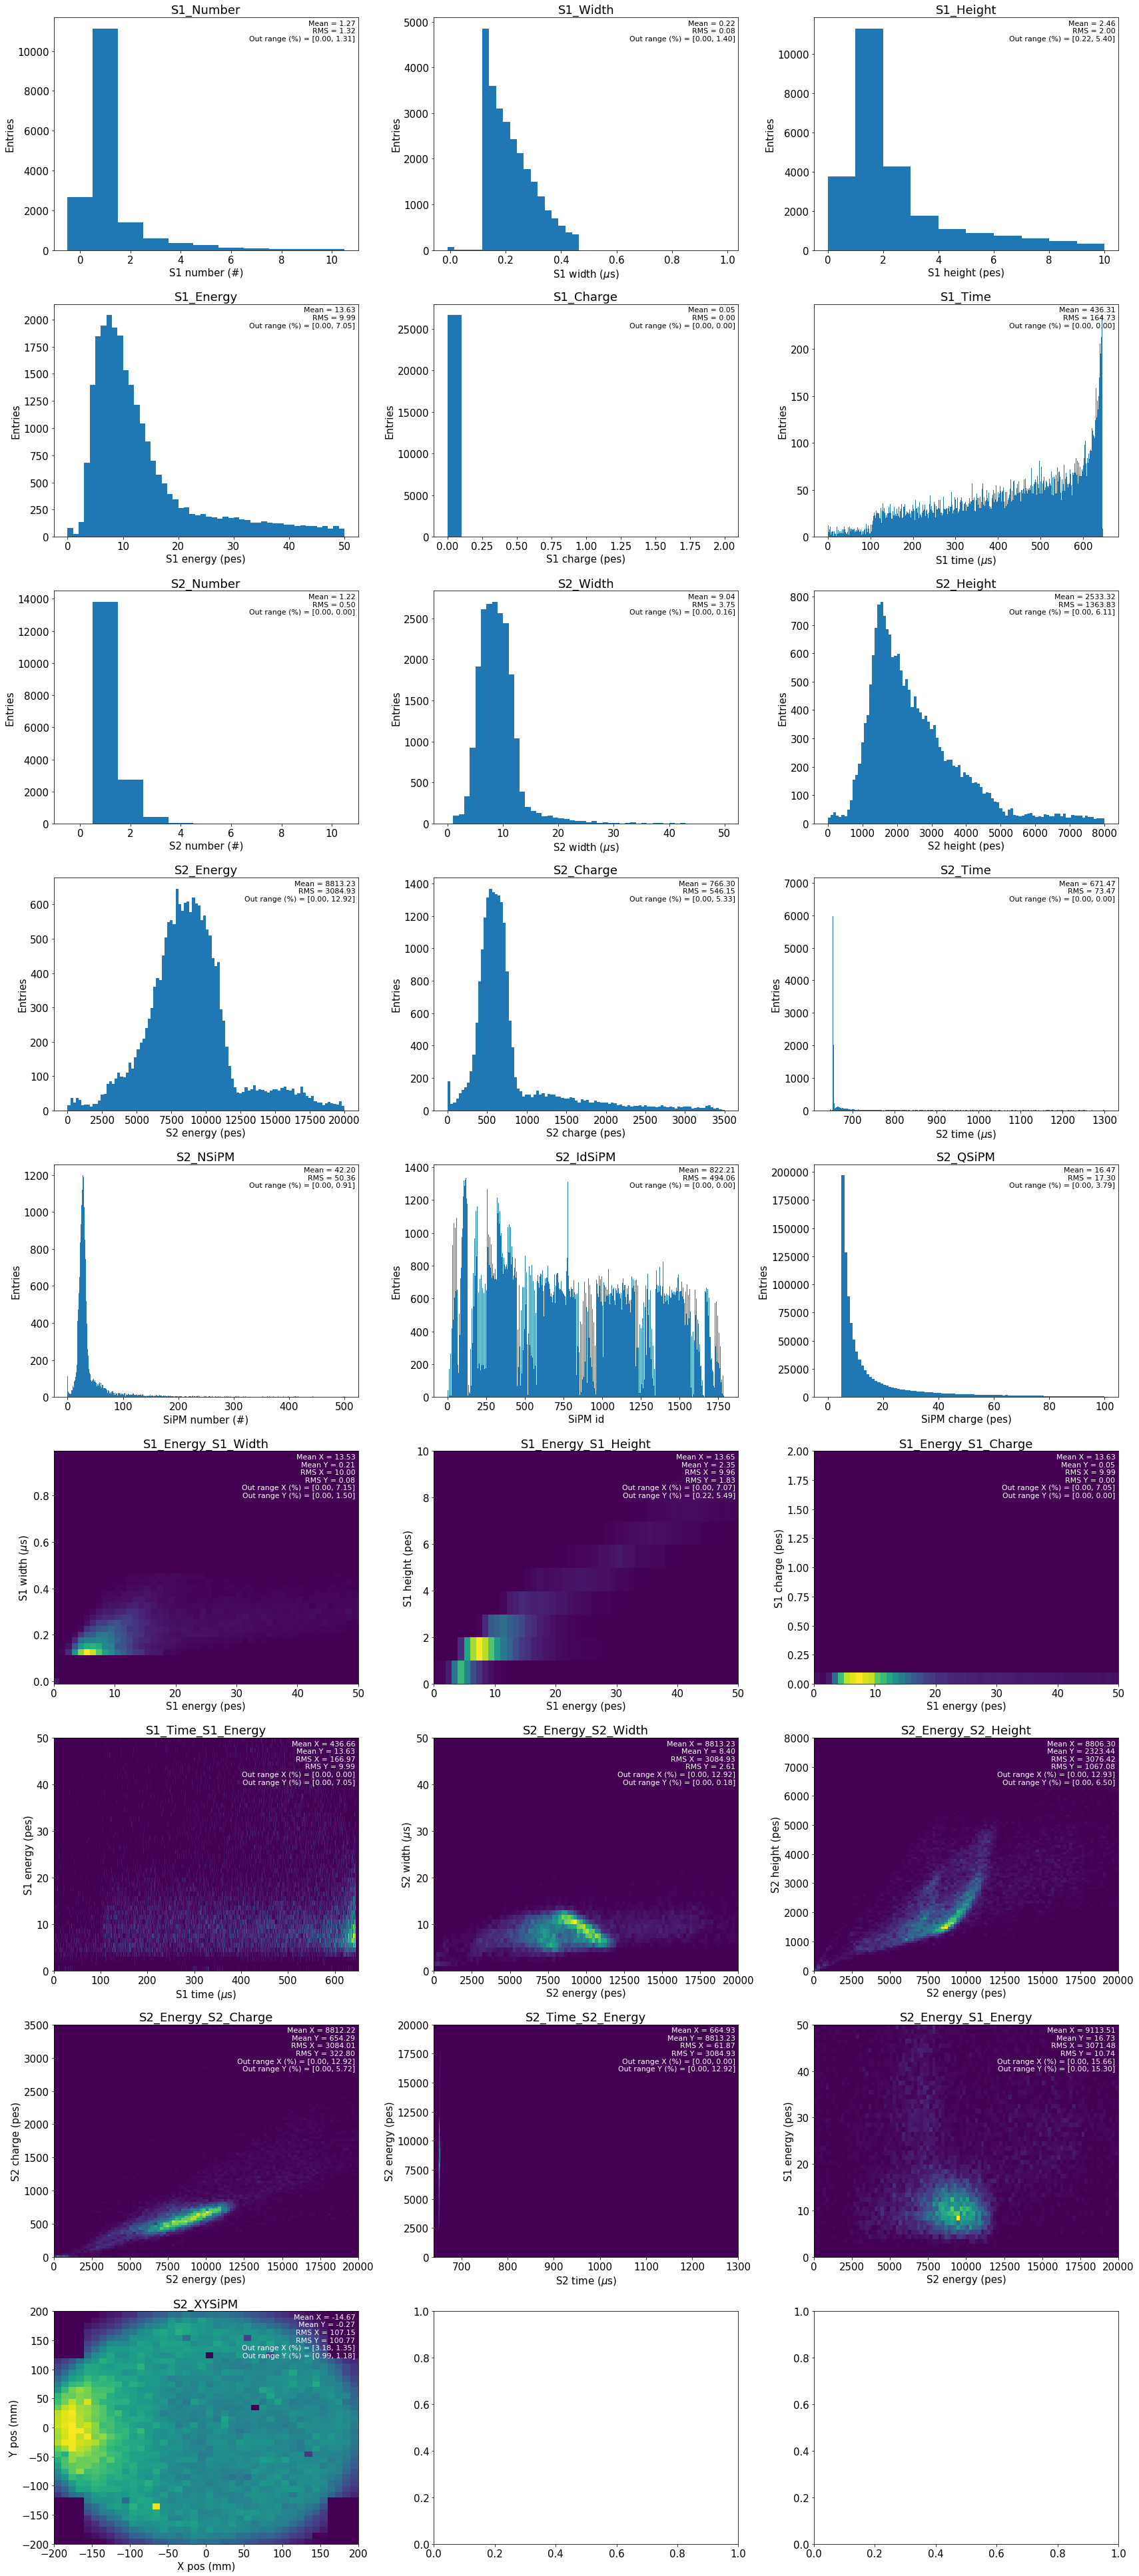

In [15]:
SMon.plot_histograms()

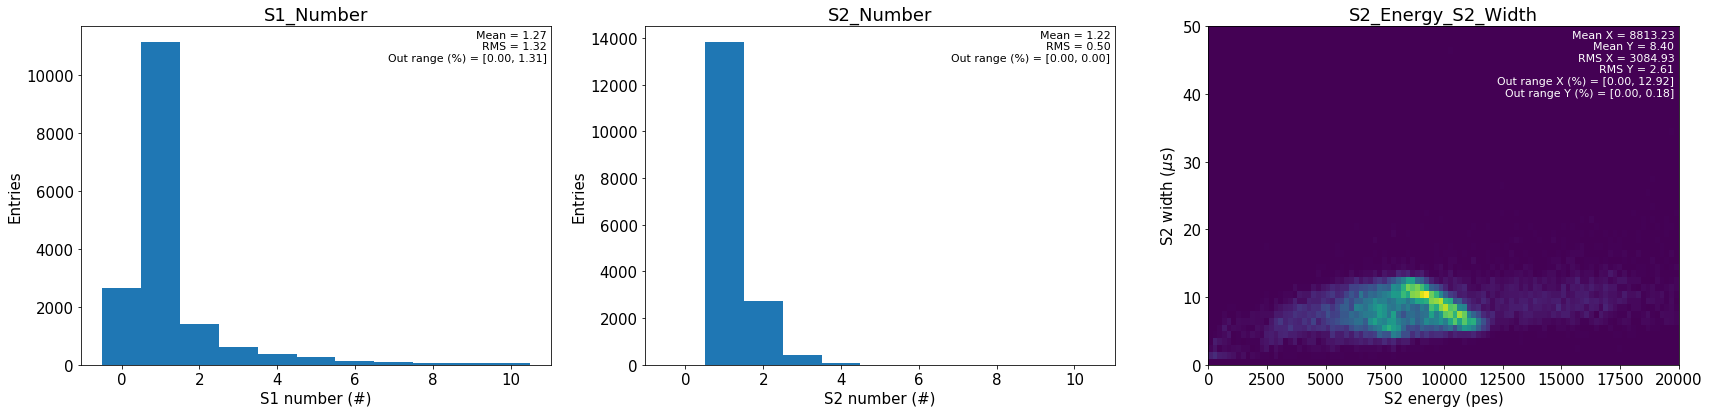

In [16]:
output = "/Users/ansimez/Documents/InvCit/hdf5/histos_pmaps.h5"
plot_histograms_from_file(output, ['S1_Number', 'S2_Number', 'S2_Energy_S2_Width'])

In [17]:
counter = 0
for file in files[:]:
    output = "/Users/ansimez/Documents/InvCit/hdf5/histos_pmaps_{}.h5".format(counter)

    SMon = HistoManager(SBins, SLabels)
    
    pmaps = load_pmaps(file)
    SVar = defaultdict(list)
    for ti, pi in enumerate(pmaps):
        fill_svar(pmaps[pi].s1s, SVar, 'S1')
        fill_svar(pmaps[pi].s2s, SVar, 'S2', SiPM_db)

    fill_2d(SVar, 'S1')
    fill_2d(SVar, 'S2')
    
    del SVar['S2_XSiPM']
    del SVar['S2_YSiPM']    
    del SVar['S2_SingleS1']
    del SVar['S2_SingleS1_Energy']
    
    SMon.fill_histograms(SVar)
    SMon.save_to_file(output)
    
    counter += 1

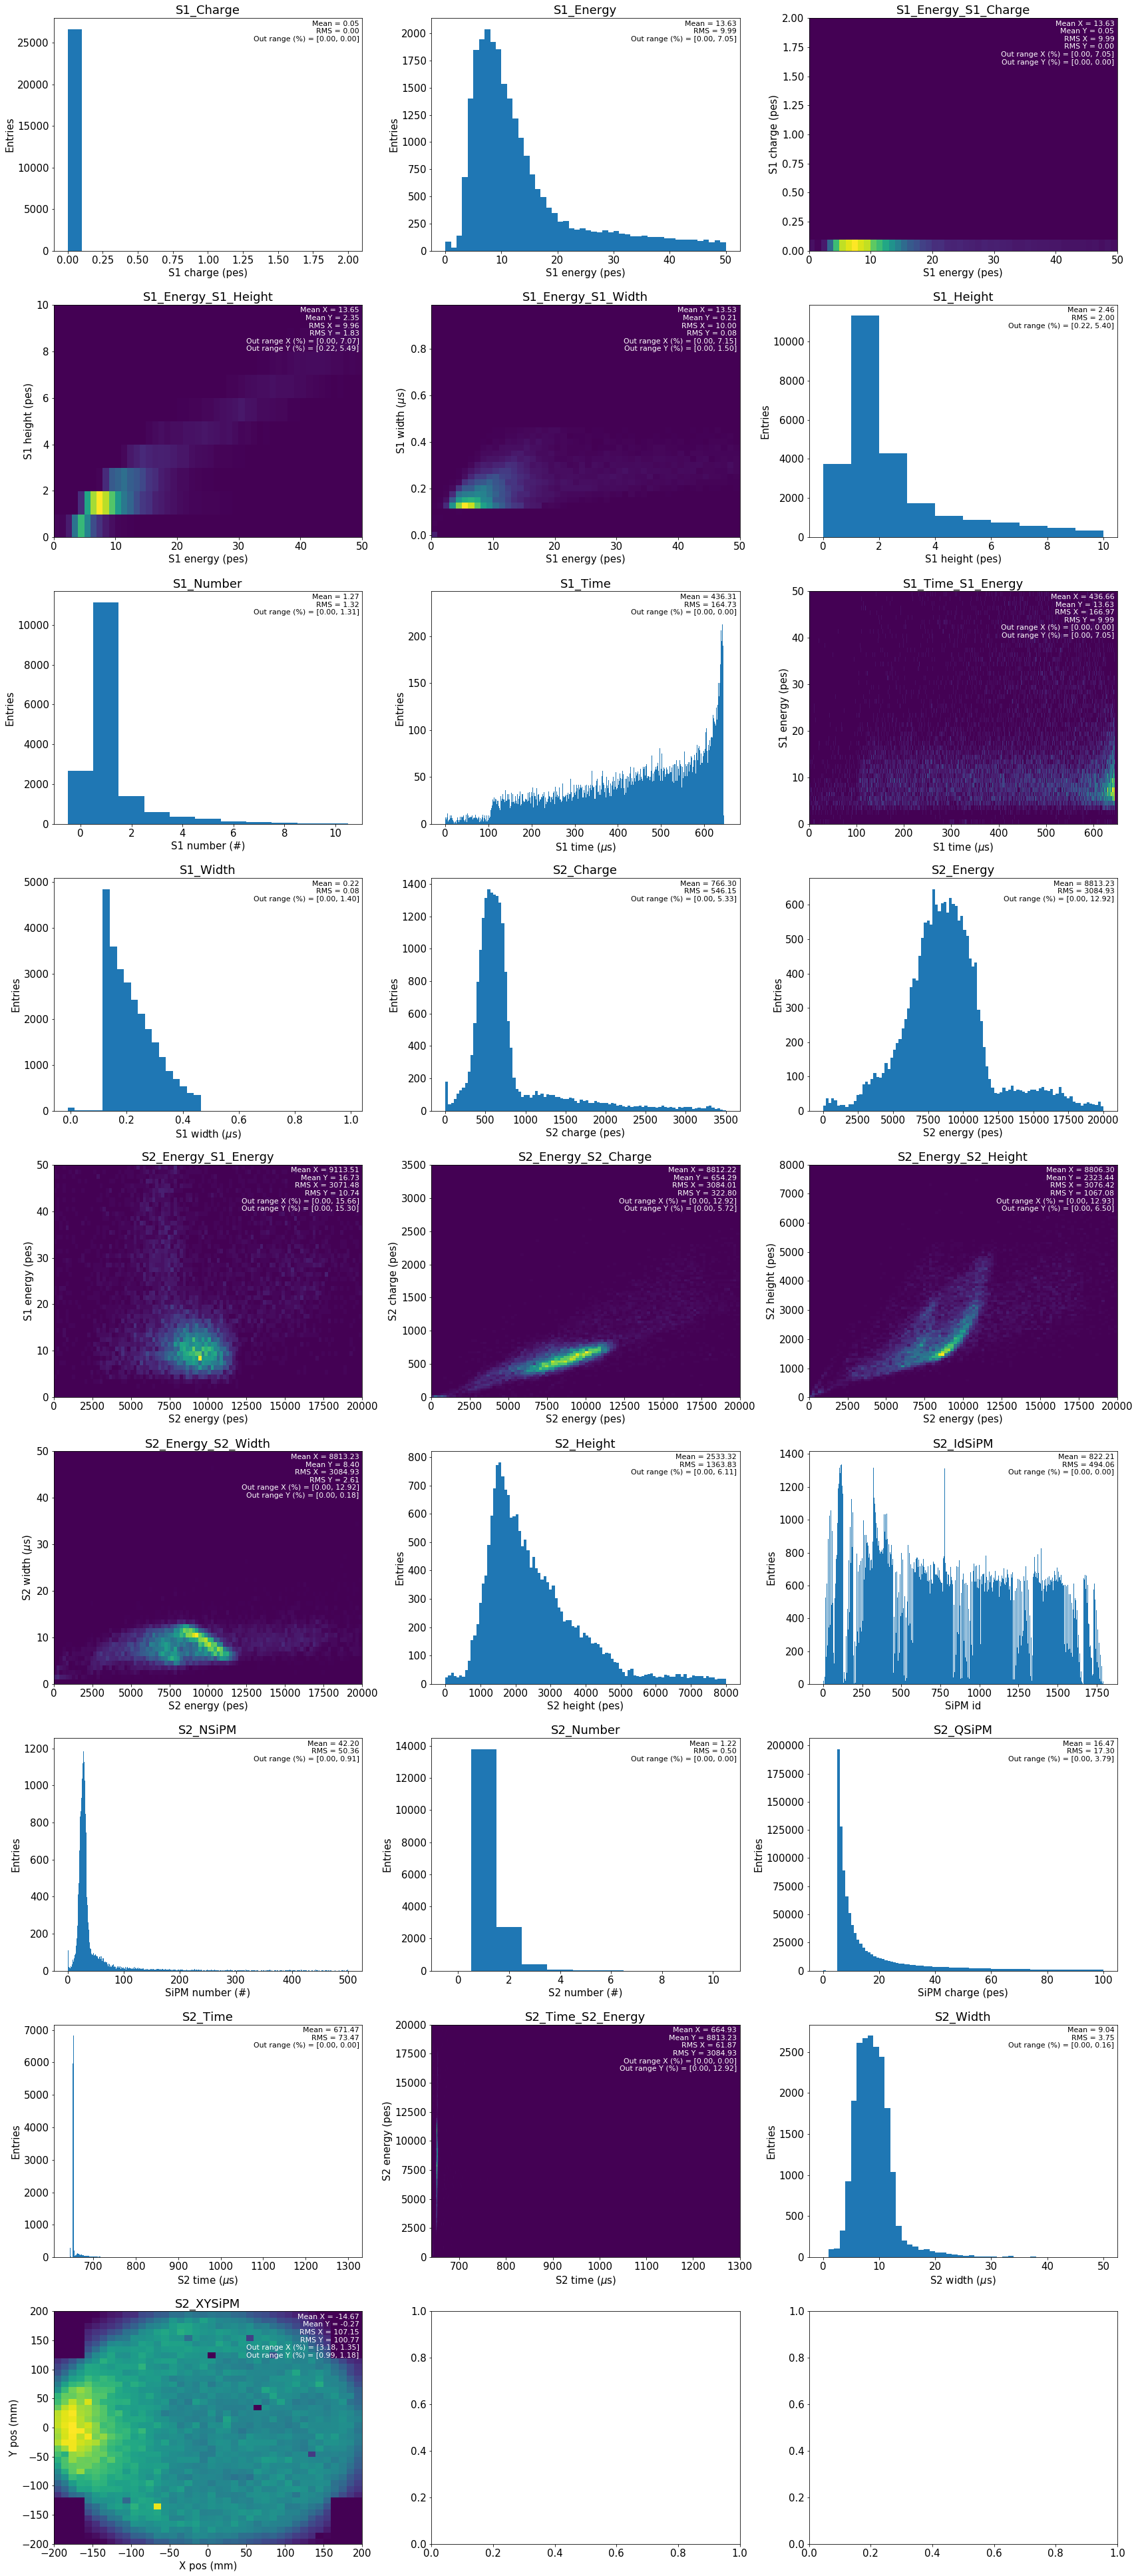

In [18]:
in_files = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/histos_pmaps_[0-9]*")
out_file = "/Users/ansimez/Documents/InvCit/hdf5/histos_pmaps_sum.h5"

add_histograms_from_files(in_files, out_file)
plot_histograms_from_file(out_file)